In [1]:
pip install magent2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 99.4 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pettingzoo==1.22.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.4/823.4 kB 17.1 MB/s eta 0:00:0000:01
  Attempting uninstall: pettingzoo
    Found existing installation: pettingzoo 1.24.0
    Uninstalling pettingzoo-1.24.0:
      Successfully uninstalled pettingzoo-1.24.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.16.9 requires pettingzoo==1.24.0, but you have pettingzoo 1.22.0 which is incompatible.
magent2 0.3.3 requires pettingzoo>=1.23.1, but you have pettingzoo 1.22.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from magent2.environments import battle_v4
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import os
import datetime
from collections import deque
import random
import math

# --- Noisy Linear Layer ---
class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, std_init=0.5):
        super(NoisyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init

        self.weight_mu = nn.Parameter(torch.empty(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.empty(out_features, in_features))
        self.register_buffer('weight_epsilon', torch.empty(out_features, in_features))

        self.bias_mu = nn.Parameter(torch.empty(out_features))
        self.bias_sigma = nn.Parameter(torch.empty(out_features))
        self.register_buffer('bias_epsilon', torch.empty(out_features))

        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        mu_range = 1 / math.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / math.sqrt(self.in_features))
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / math.sqrt(self.out_features))

    def _scale_noise(self, size):
        x = torch.randn(size)
        return x.sign().mul_(x.abs().sqrt_())

    def reset_noise(self):
        epsilon_in = self._scale_noise(self.in_features)
        epsilon_out = self._scale_noise(self.out_features)
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)

    def forward(self, input):
        if self.training:
            return nn.functional.linear(input, self.weight_mu + self.weight_sigma * self.weight_epsilon, self.bias_mu + self.bias_sigma * self.bias_epsilon)
        else:
            return nn.functional.linear(input, self.weight_mu, self.bias_mu)

# --- Dueling Q-Network with Noisy Layers ---
class DuelingNoisyQNetwork(nn.Module):
    def __init__(self, observation_shape, action_shape):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.ReLU(),
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.ReLU(),
        )
        dummy_input = torch.randn(observation_shape).permute(2, 0, 1).unsqueeze(0)
        dummy_output = self.cnn(dummy_input)
        flatten_dim = dummy_output.view(-1).shape[0]

        self.fc_value = nn.Sequential(
            NoisyLinear(flatten_dim, 120),
            nn.ReLU(),
            NoisyLinear(120, 1)
        )

        self.fc_advantage = nn.Sequential(
            NoisyLinear(flatten_dim, 120),
            nn.ReLU(),
            NoisyLinear(120, action_shape)
        )

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = self.cnn(x)
        x = x.reshape(x.size(0), -1)
        value = self.fc_value(x)
        advantage = self.fc_advantage(x)
        return value + advantage - advantage.mean(dim=1, keepdim=True)

    def reset_noise(self):
        for m in self.modules():
            if isinstance(m, NoisyLinear):
                m.reset_noise()


In [4]:
# --- Prioritized Replay Buffer ---
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6, beta_start=0.4, beta_frames=100000):
        self.capacity = capacity
        self.buffer = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.alpha = alpha
        self.beta_start = beta_start
        self.beta_frames = beta_frames
        self.frame = 1
        self.pos = 0
        self.max_priority = 1.0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done)

        self.priorities[self.pos] = self.max_priority
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]

        probs = prios ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]

        beta = self.beta_start + (1.0 - self.beta_start) * self.frame / self.beta_frames
        self.frame = min(self.frame + 1, self.beta_frames)

        weights = (len(self.buffer) * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights = np.array(weights, dtype=np.float32)

        state, action, reward, next_state, done = zip(*samples)
        return state, action, reward, next_state, done, indices, weights

    def update_priorities(self, batch_indices, batch_priorities):
        for idx, prio in zip(batch_indices, batch_priorities):
            self.priorities[idx] = prio
            self.max_priority = max(self.max_priority, prio)

    def __len__(self):
        return len(self.buffer)


In [5]:
# --- Function to evaluate a checkpoint ---
def evaluate_checkpoint(q_network, num_episodes=5):
    env = battle_v4.parallel_env(map_size=45, max_cycles=1000, minimap_mode=False) 
    total_steps = 0
    total_rewards = 0
    for _ in range(num_episodes):
        observations = env.reset()
        done_agents = set()
        steps = 0
        episode_reward = 0
        while True:
            actions = {}
            red_agents = [agent for agent in env.agents if agent.startswith("red_") and agent not in done_agents]
            blue_agents = [agent for agent in env.agents if agent.startswith("blue_") and agent not in done_agents]

            if blue_agents:
                states_blue = torch.stack([
                    torch.tensor(observations[agent], dtype=torch.float32)
                    for agent in blue_agents
                ]).to(device)
                with torch.no_grad():
                    q_network.reset_noise() # Reset noise before action selection
                    q_values_blue = q_network(states_blue)
                    selected_actions_blue = torch.argmax(q_values_blue, dim=1)

                for idx, agent in enumerate(blue_agents):
                    actions[agent] = selected_actions_blue[idx].item()
            
            if red_agents:
                for idx, agent in enumerate(red_agents):
                  actions[agent] = env.action_spaces[agent].sample()

            next_obs, rewards, terminations, truncations, infos = env.step(actions)

            # Update done_agents based on terminations
            done_agents.update([agent for agent, terminated in terminations.items() if terminated])

            observations = next_obs
            steps += 1

            episode_reward += sum(rewards.get(agent, 0.0) for agent in blue_agents)

            # Check if all agents are done (either terminated or truncated)
            if all(terminations.values()) or all(truncations.values()):
                total_steps += steps
                total_rewards += episode_reward
                break
    return total_steps / num_episodes, total_rewards / num_episodes


In [6]:
# --- Initialize environment and device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- TensorBoard writer ---
log_dir = os.path.join("runs", "Dueling_Noisy_DDQN_BattleV4_PER_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = SummaryWriter(log_dir=log_dir)

# --- Initialize the environment ---
env = battle_v4.parallel_env(map_size=45, max_cycles=1000, minimap_mode=False)

sample_observation = env.observation_spaces[env.agents[0]].shape
state_space = sample_observation
action_space = env.action_spaces[env.agents[0]].n

# --- Initialize networks and optimizers ---
q_network_blue = DuelingNoisyQNetwork(state_space, action_space).to(device)
target_network_blue = DuelingNoisyQNetwork(state_space, action_space).to(device)
target_network_blue.load_state_dict(q_network_blue.state_dict())
target_network_blue.eval()

optimizer_blue = optim.Adam(q_network_blue.parameters(), lr=0.0005)

# --- Hyperparameters ---
gamma = 0.99
num_episodes = 250
max_steps_per_episode = 1000
checkpoint_interval = 5
polyak_tau = 0.005
replay_buffer_size = 500000
batch_size = 1024
num_val_episodes = 5

# --- Initialize prioritized replay buffers ---
replay_buffer_blue = PrioritizedReplayBuffer(replay_buffer_size)
# --- Training loop ---
best_val = float('inf')
best_checkpoint = ""
for episode in range(0, num_episodes + 1):
    observations = env.reset()
    total_reward_blue = 0
    done_agents = set()

    for step in range(max_steps_per_episode):
        actions = {}
        red_agents = [agent for agent in env.agents if agent.startswith("red_") and agent not in done_agents]
        blue_agents = [agent for agent in env.agents if agent.startswith("blue_") and agent not in done_agents]

        # --- Process all blue agents ---
        if blue_agents:
            states_blue = torch.stack([
                torch.tensor(observations[agent], dtype=torch.float32)
                for agent in blue_agents
            ]).to(device)

            # --- Select actions with Noisy Networks ---
            q_network_blue.reset_noise()
            with torch.no_grad():
                q_values_blue = q_network_blue(states_blue)
                selected_actions_blue = torch.argmax(q_values_blue, dim=1)

            for idx, agent in enumerate(blue_agents):
                actions[agent] = selected_actions_blue[idx].item()

        # --- Process all red agents ---
        if red_agents:
            selected_actions_red = torch.randint(0, action_space, (len(red_agents),), device=device)
            for idx, agent in enumerate(red_agents):
                actions[agent] = selected_actions_red[idx].item()

        # --- Take step in environment ---
        
        next_obs, rewards, terminations, truncations, infos = env.step(actions)
        # --- Update total rewards ---
        total_reward_blue += sum(rewards.get(agent, 0.0) for agent in blue_agents)
        # --- Store experiences in replay buffers ---
        for agent in blue_agents:
            next_state = next_obs.get(agent) if not terminations.get(agent, False) else observations[agent]  # Use current state as next state if agent is done
            replay_buffer_blue.push(
                observations[agent],
                actions[agent],
                rewards.get(agent, 0.0),
                next_state,
                terminations.get(agent, False)  # Only consider termination as done
            )
        # --- Train blue network on a batch sampled from replay buffer ---
        if len(replay_buffer_blue) >= batch_size:
            state_batch, action_batch, reward_batch, next_state_batch, done_batch, indices, weights = replay_buffer_blue.sample(batch_size)

            current_states_blue = torch.tensor(np.array(state_batch), dtype=torch.float32).to(device)
            current_actions_blue = torch.tensor(action_batch, dtype=torch.long).unsqueeze(1).to(device)
            next_states_blue = torch.tensor(np.array(next_state_batch), dtype=torch.float32).to(device)
            rewards_blue = torch.tensor(reward_batch, dtype=torch.float32).unsqueeze(1).to(device)
            dones_blue = torch.tensor(done_batch, dtype=torch.float32).unsqueeze(1).to(device)
            weights_tensor_blue = torch.tensor(weights, dtype=torch.float32).unsqueeze(1).to(device)

            q_network_blue.reset_noise()
            target_network_blue.reset_noise()
            current_q_values_blue = q_network_blue(current_states_blue).gather(1, current_actions_blue)
            with torch.no_grad():
                actions = q_network_blue(next_states_blue).max(1, keepdim=True)[1]
                next_q_values_blue = target_network_blue(next_states_blue).gather(1, actions)
                target_q_values_blue = rewards_blue + gamma * next_q_values_blue * (1 - dones_blue)

            td_errors = (target_q_values_blue - current_q_values_blue).abs().detach().cpu().numpy()
            new_priorities = td_errors + 1e-6
            replay_buffer_blue.update_priorities(indices, new_priorities)

            loss_blue = (weights_tensor_blue * nn.SmoothL1Loss(reduction='none')(current_q_values_blue, target_q_values_blue)).mean()

            optimizer_blue.zero_grad()
            loss_blue.backward()
            nn.utils.clip_grad_norm_(q_network_blue.parameters(), 1.0)
            optimizer_blue.step()

            writer.add_scalar('Loss/Blue', loss_blue.item(), episode * max_steps_per_episode + step)

        # --- Soft update target networks ---
        for target_param, param in zip(target_network_blue.parameters(), q_network_blue.parameters()):
            target_param.data.copy_(polyak_tau * param.data + (1 - polyak_tau) * target_param.data)

        observations = next_obs
        done_agents.update([agent for agent, terminated in terminations.items() if terminated])

        if all(terminations.values()) or (truncations and all(truncations.values())):
            break

    # --- Log episode statistics ---
    writer.add_scalar('Total Reward/Blue', total_reward_blue, episode)
    print(f"Episode {episode}/{num_episodes}, Total Reward Blue: {total_reward_blue:.2f}")

    # --- Save checkpoints and evaluate ---
    if episode % checkpoint_interval == 0:
        checkpoint_path = f"blue_agent_dueling_noisy_ddqn_per_ep{episode}.pth"
        torch.save(q_network_blue.state_dict(), checkpoint_path)

        val, val_reward = evaluate_checkpoint(q_network_blue, num_val_episodes)
        writer.add_scalar('Validation/Average Steps', val, episode)
        writer.add_scalar('Validation/Average Reward', val_reward, episode)
        print(f"Episode {episode}: Validation average steps = {val:.2f}, Validation average reward = {val_reward:.2f}")

        if val <= best_val:
            best_val = val
            if best_checkpoint:
                os.remove(best_checkpoint)
            print(f"New best checkpoint saved at {best_checkpoint} with average steps {best_val:.2f}")
        if val > best_val:
            os.remove(checkpoint_path)
if best_checkpoint:
    best_checkpoint_final = "blue_agent_dueling_noisy_ddqn_per_best.pth"
    os.rename(best_checkpoint, best_checkpoint_final)
    print(f"Training complete. Best model saved at {best_checkpoint_final}")
else:
    torch.save(q_network_blue.state_dict(), "blue_agent_dueling_noisy_ddqn_per_final.pth")
    print(f"Training complete. Final model saved at blue_agent_dueling_noisy_ddqn_per_final.pth")

Using device: cuda


/tmp/ipykernel_69/2464537133.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = prio
/tmp/ipykernel_69/2464537133.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[self.pos] = self.max_priority


Episode 0/250, Total Reward Blue: -1562.90
Episode 0: Validation average steps = 1000.00, Validation average reward = -2365.84
New best checkpoint saved at  with average steps 1000.00
Episode 1/250, Total Reward Blue: -818.40
Episode 2/250, Total Reward Blue: -408.60
Episode 3/250, Total Reward Blue: -404.41
Episode 4/250, Total Reward Blue: -8.18
Episode 5/250, Total Reward Blue: 195.93
Episode 5: Validation average steps = 816.20, Validation average reward = 2.18
New best checkpoint saved at  with average steps 816.20
Episode 6/250, Total Reward Blue: 198.96
Episode 7/250, Total Reward Blue: 351.12
Episode 8/250, Total Reward Blue: 349.68
Episode 9/250, Total Reward Blue: 372.64
Episode 10/250, Total Reward Blue: 371.20
Episode 10: Validation average steps = 61.80, Validation average reward = 386.46
New best checkpoint saved at  with average steps 61.80
Episode 11/250, Total Reward Blue: 386.11
Episode 12/250, Total Reward Blue: 381.96
Episode 13/250, Total Reward Blue: 385.45
Episod

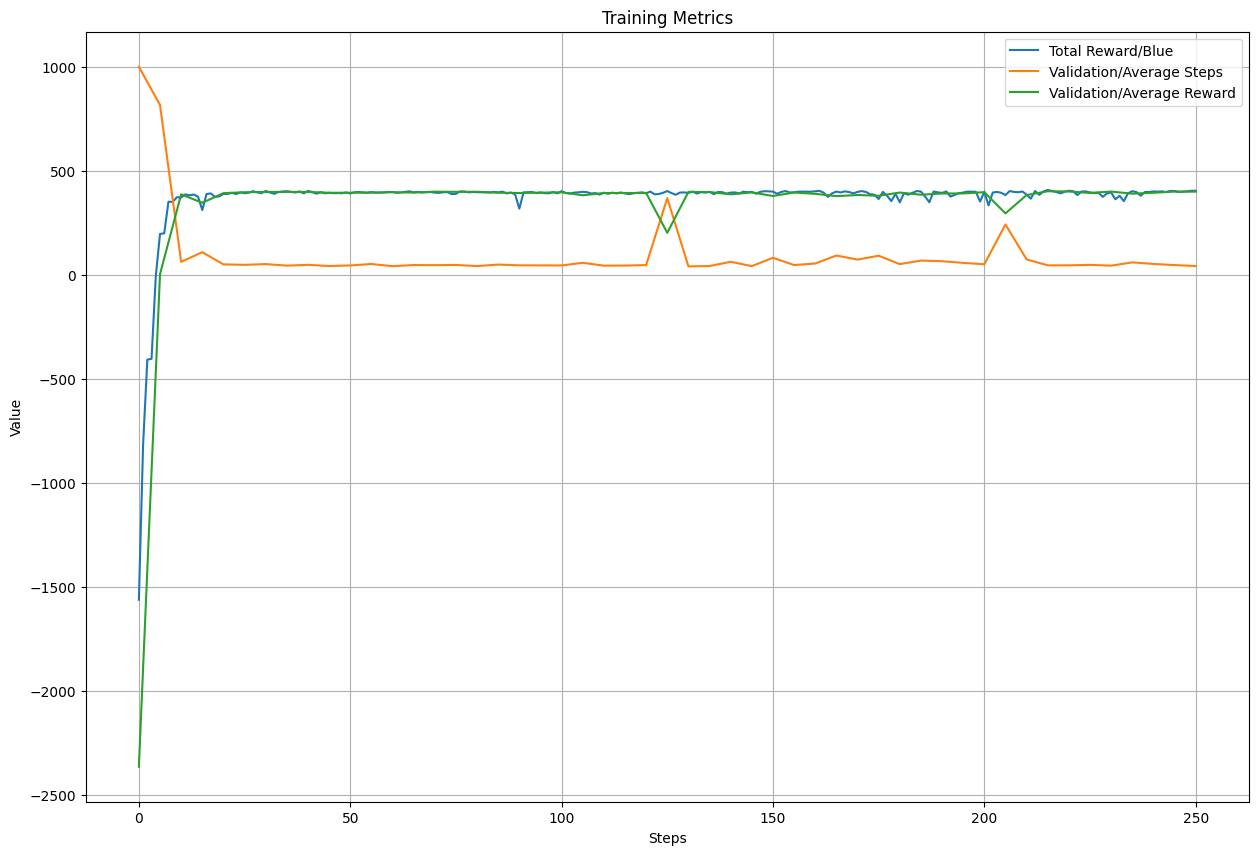

In [9]:
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os

# --- Function to extract data from TensorBoard logs ---
def extract_data_from_logs(log_dir, tags):
    event_acc = EventAccumulator(log_dir)
    event_acc.Reload()
    data = {tag: [] for tag in tags}

    for tag in tags:
        events = event_acc.Scalars(tag)
        for event in events:
            data[tag].append((event.step, event.value))

    return data

# --- Set log directory ---
log_dir = "/kaggle/working/runs"  # Replace with the directory where TensorBoard logs are stored
latest_run = max([os.path.join(log_dir, d) for d in os.listdir(log_dir)], key=os.path.getmtime)

# --- Tags to plot ---
tags_to_plot = ['Total Reward/Blue','Validation/Average Steps','Validation/Average Reward']
data = extract_data_from_logs(latest_run, tags_to_plot)

# --- Plot data ---
plt.figure(figsize=(15, 10))
for tag in tags_to_plot:
    steps, values = zip(*data[tag])
    plt.plot(steps, values, label=tag)

plt.xlabel("Steps")
plt.ylabel("Value")
plt.title("Training Metrics")
plt.legend()
plt.grid(True)
plt.show()
